# House Price Prediction using XGBoost

This notebook addresses the Kaggle "House Prices - Advanced Regression Techniques" competition. Our objective is to build a robust and accurate model to predict the final sale price of residential homes, utilizing a comprehensive dataset with 79 explanatory variables.

We will focus on XGBoost (eXtreme Gradient Boosting), a highly efficient and popular machine learning algorithm that consistently delivers top-tier performance on tabular data. 

## Importing necessary libraries and modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

## Loading the data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
full = pd.concat([train, test], axis=0)

## Initial data inspection

In [3]:
print("Train dataset shape - ", train.shape)
print("Test dataset shape - ", test.shape)
print("Full dataset shape [train and test data] - ", full.shape)

Train dataset shape -  (1460, 81)
Test dataset shape -  (1459, 80)
Full dataset shape [train and test data] -  (2919, 81)


In [4]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallCond  

In [5]:
numeric_df = full.select_dtypes(include='number')
object_df = full.select_dtypes(include='object')

print("Numeric features",numeric_df.shape[1])
print("Categorical features",object_df.shape[1])

Numeric features 38
Categorical features 43


### Finding highly skewed features

Skewness, indicating asymmetry in a distribution, impacts many machine learning models which assume normally distributed features, potentially leading to biased or inaccurate predictions. It also highlights the presence of outliers, especially in the longer tail, guiding their treatment. Furthermore, skewness influences central tendency measures, making the median a more reliable metric than the mean for skewed data. Crucially, detecting skewness informs the need for data transformationsto normalize distributions, improving model performance, statistical inference, and overall data interpretability.

In [6]:
skewness = numeric_df.skew().sort_values(ascending=False)

# Filter features with high skewness
high_skew = skewness[abs(skewness) > 0.75]
print("Highly skewed features:")
print(high_skew)

Highly skewed features:
MiscVal          21.958480
PoolArea         16.907017
LotArea          12.829025
LowQualFinSF     12.094977
3SsnPorch        11.381914
KitchenAbvGr      4.304467
BsmtFinSF2        4.147456
EnclosedPorch     4.005950
ScreenPorch       3.948723
BsmtHalfBath      3.932018
MasVnrArea        2.602589
OpenPorchSF       2.536417
SalePrice         1.882876
WoodDeckSF        1.843380
LotFrontage       1.503278
1stFlrSF          1.470360
BsmtFinSF1        1.425722
MSSubClass        1.376165
GrLivArea         1.270010
TotalBsmtSF       1.162882
BsmtUnfSF         0.919824
2ndFlrSF          0.862118
TotRmsAbvGrd      0.758757
dtype: float64


### Finding Missing Values

In [7]:
missing_values = full.isnull().sum()
# Filter out rows where the sum of missing values is 0
non_zero_missing_values = missing_values[missing_values > 0]

print("Missing values (only non-zero counts):\n", non_zero_missing_values.sort_values(ascending=False))
print("\nDuplicates:", train.duplicated().sum())

Missing values (only non-zero counts):
 PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
MasVnrType      1766
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrArea        23
MSZoning           4
Utilities          2
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF2         1
GarageCars         1
KitchenQual        1
GarageArea         1
SaleType           1
dtype: int64

Duplicates: 0


### House Price Distribution

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

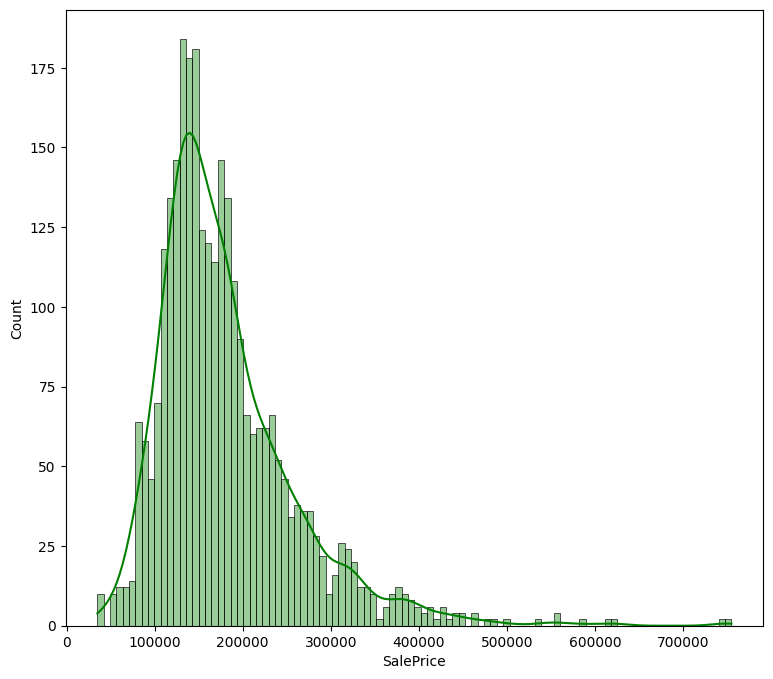

In [8]:
print(full['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.histplot(data=full, x='SalePrice', color='g', bins=100, alpha=0.4, kde=True)

### Numerical Features distribution

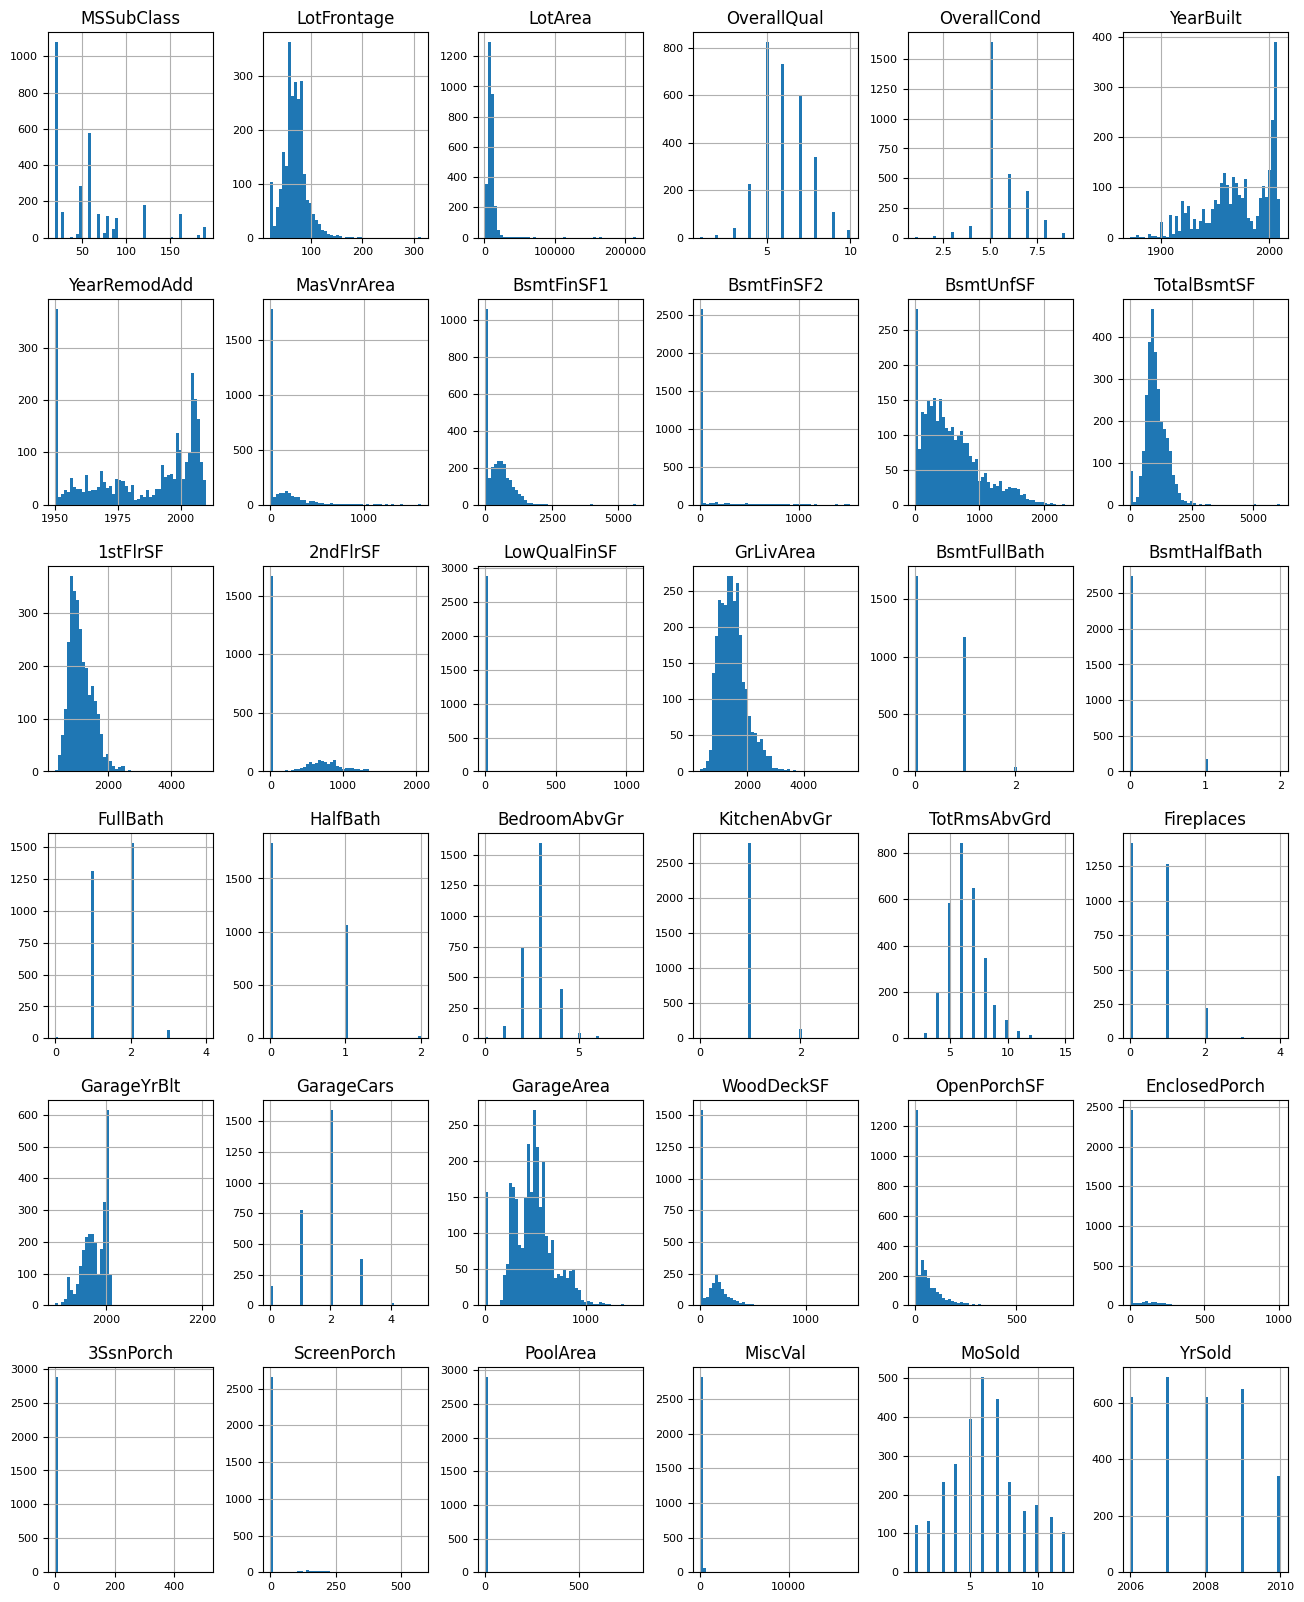

In [9]:
numeric_df.drop(columns =['Id',"SalePrice"],inplace = False).hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Finding columns to drop based on missing value percentage

Dropping columns with a high percentage of missing values is crucial in data preprocessing. Such columns offer minimal useful information, akin to being empty, making them unreliable for analysis. Attempting to impute a large volume of missing data can introduce significant bias, noise, or fabricate patterns, leading to inaccurate model predictions. Furthermore, many machine learning models perform poorly or fail when faced with pervasive missingness. Removing these columns simplifies the dataset, reduces dimensionality, and improves model stability and performance by ensuring the input features are meaningful and well-represented.

In [10]:
many_na_columns = non_zero_missing_values[non_zero_missing_values >= 0.25 * len(full)]
print(f"Percentage of NA values above 40% of the data :\n\n{many_na_columns / len(full)}")

Percentage of NA values above 40% of the data :

Alley          0.932169
MasVnrType     0.605002
FireplaceQu    0.486468
PoolQC         0.996574
Fence          0.804385
MiscFeature    0.964029
SalePrice      0.499829
dtype: float64


In [11]:
few_na_columns = non_zero_missing_values[non_zero_missing_values <= 0.25 * len(full)]
print(f"Percentage of NA values above 40% of the data :\n\n{few_na_columns / len(full)}")

Percentage of NA values above 40% of the data :

MSZoning        0.001370
LotFrontage     0.166495
Utilities       0.000685
Exterior1st     0.000343
Exterior2nd     0.000343
MasVnrArea      0.007879
BsmtQual        0.027749
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtFinType1    0.027064
BsmtFinSF1      0.000343
BsmtFinType2    0.027407
BsmtFinSF2      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Electrical      0.000343
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
KitchenQual     0.000343
Functional      0.000685
GarageType      0.053786
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageCars      0.000343
GarageArea      0.000343
GarageQual      0.054471
GarageCond      0.054471
SaleType        0.000343
dtype: float64


In [12]:
for col in few_na_columns.index[0:]:
    print(full[col].value_counts(dropna=False))
    print("="*30)

MSZoning
RL         2265
RM          460
FV          139
RH           26
C (all)      25
NaN           4
Name: count, dtype: int64
LotFrontage
NaN      486
60.0     276
80.0     137
70.0     133
50.0     117
        ... 
155.0      1
126.0      1
200.0      1
131.0      1
133.0      1
Name: count, Length: 129, dtype: int64
Utilities
AllPub    2916
NaN          2
NoSeWa       1
Name: count, dtype: int64
Exterior1st
VinylSd    1025
MetalSd     450
HdBoard     442
Wd Sdng     411
Plywood     221
CemntBd     126
BrkFace      87
WdShing      56
AsbShng      44
Stucco       43
BrkComm       6
AsphShn       2
Stone         2
CBlock        2
ImStucc       1
NaN           1
Name: count, dtype: int64
Exterior2nd
VinylSd    1014
MetalSd     447
HdBoard     406
Wd Sdng     391
Plywood     270
CmentBd     126
Wd Shng      81
BrkFace      47
Stucco       47
AsbShng      38
Brk Cmn      22
ImStucc      15
Stone         6
AsphShn       4
CBlock        3
Other         1
NaN           1
Name: count, dty

In [13]:
train_clean = train.copy()
test_clean = test.copy()

### Based On the above analyse:

1] LotFrontage column have few NA values and need log transform on it, NA values will be the column median.

2] Street and Alley columns are talking about the same thing and even same categories, but Alley records are almost full of NA values. We should drop Alley column.

3] PoolQC, Fence, MiscFeature, MasVnrType columns should be dropped because of their high percentage of NA values.

4] In FireplaceQu column, NA values means there is no fireplace, so it gives a meaning and we should not drop it.

5] Utilities column has about one category, so we should drop it.MSZoning, Exterior1st, Exterior2nd, Electrical, KitchenQual, Functional, SaleType columns' NA values should be substituted with Mode of each column.

6] MasVnrArea, TotalBsmtSF, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, GarageCars, GarageArea, BsmtFullBath, BsmtHalfBath columns' NA values should be substituted with 0 and these columns need log transform.

7] BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageFinish, GarageQual, GarageCond columns' NA values should be substituted with NA category.

In [14]:
cols_to_drop = [ "Alley", "PoolQC", "Fence", "MiscFeature", "MasVnrType", "Utilities"]
train_clean = train_clean.drop(cols_to_drop, axis=1)
test_clean = test_clean.drop(cols_to_drop, axis=1)

In [15]:
median_lotfrontage = train_clean["LotFrontage"].median()
train_clean["LotFrontage"] = train_clean["LotFrontage"].fillna(median_lotfrontage)
test_clean["LotFrontage"] = test_clean["LotFrontage"].fillna(median_lotfrontage)

In [16]:
cols_to_NA_category = ["FireplaceQu", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
                       "BsmtFinType2", "GarageType", "GarageFinish", "GarageQual", "GarageCond"]

for col in cols_to_NA_category:
    train_clean[col] = train_clean[col].fillna("NA")
    test_clean[col] = test_clean[col].fillna("NA")

    print(train_clean[col].value_counts(dropna=False))
    print("="*30)

FireplaceQu
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64
BsmtQual
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: count, dtype: int64
BsmtCond
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: count, dtype: int64
BsmtExposure
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: count, dtype: int64
BsmtFinType1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: count, dtype: int64
BsmtFinType2
Unf    1256
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: count, dtype: int64
GarageType
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64
GarageFinish
Unf    605
RFn    422
Fin    352
NA      81
Name: count, dtype: int64
GarageQual
TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: count, dtype: int64
GarageCond
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex   

In [17]:
cols_to_zero = ["MasVnrArea", "TotalBsmtSF", "BsmtFinSF1","BsmtHalfBath",
                "BsmtFinSF2", "BsmtUnfSF","BsmtFullBath","GarageCars", "GarageArea","GarageYrBlt"]

for col in cols_to_zero:
    train_clean[col] = train_clean[col].fillna(0)
    test_clean[col] = test_clean[col].fillna(0)

    print(train_clean[col].value_counts(dropna=False))
    print("="*30)

MasVnrArea
0.0      869
108.0      8
72.0       8
180.0      8
120.0      7
        ... 
788.0      1
86.0       1
796.0      1
391.0      1
119.0      1
Name: count, Length: 327, dtype: int64
TotalBsmtSF
0       37
864     35
672     17
912     15
1040    14
        ..
1902     1
1274     1
1393     1
1622     1
1352     1
Name: count, Length: 721, dtype: int64
BsmtFinSF1
0      467
24      12
16       9
616      5
20       5
      ... 
774      1
35       1
984      1
668      1
459      1
Name: count, Length: 637, dtype: int64
BsmtHalfBath
0    1378
1      80
2       2
Name: count, dtype: int64
BsmtFinSF2
0       1293
180        5
374        3
93         2
287        2
        ... 
872        1
110        1
627        1
163        1
1029       1
Name: count, Length: 144, dtype: int64
BsmtUnfSF
0       118
728       9
384       8
300       7
572       7
       ... 
204       1
1566      1
207       1
649       1
1228      1
Name: count, Length: 780, dtype: int64
BsmtFullBath
0    856

In [18]:
cols_to_mode = ["MSZoning", "Exterior1st", "Exterior2nd", "Electrical", 
                "KitchenQual", "Functional",  "SaleType"]

for col in cols_to_mode:
    mode = train_clean[col].mode()
    train_clean[col] = train_clean[col].fillna(mode[0])
    test_clean[col] = test_clean[col].fillna(mode[0])

    print(train_clean[col].value_counts(dropna=False))
    print("="*30)

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
Exterior1st
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: count, dtype: int64
Exterior2nd
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: count, dtype: int64
Electrical
SBrkr    1335
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64
KitchenQual
TA    735
Gd    586
Ex    100
Fa     39
Name: count, dtype: int64
Functional
Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: count, dtype: int64
SaleType
WD       1267
New     

In [19]:
train_clean.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 75, dtype: int64

In [20]:
test_clean.isna().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 74, dtype: int64

## Feature Engineering

In [21]:
full['TotalBath'] = (full['FullBath'] + 0.5 * full['HalfBath']
                       + full['BsmtFullBath'] + 0.5 * full['BsmtHalfBath'])
full['TotalSF'] = (full['TotalBsmtSF']
                     + full['1stFlrSF'] + full['2ndFlrSF'])
full['Age'] = full['YrSold']- full['YearBuilt']

In [22]:
train['TotalBath'] = (train['FullBath'] + 0.5 * train['HalfBath']
                       + train['BsmtFullBath'] + 0.5 * train['BsmtHalfBath'])
train['TotalSF'] = (train['TotalBsmtSF']
                     + train['1stFlrSF'] + train['2ndFlrSF'])
train['Age'] = train['YrSold']- train['YearBuilt']

In [23]:
test['TotalBath'] = (test['FullBath'] + 0.5 * test['HalfBath']
                       + test['BsmtFullBath'] + 0.5 * test['BsmtHalfBath'])
test['TotalSF'] = (test['TotalBsmtSF']
                     + test['1stFlrSF'] + test['2ndFlrSF'])
test['Age'] = test['YrSold']- test['YearBuilt']

## Encoding categorical features using Ordinal Encoder

In [24]:
cat_train_df = train_clean.select_dtypes(include="object")
cat_test_df = test_clean.select_dtypes(include="object")

In [25]:
cat_cols = train_clean.select_dtypes(include="object").columns

combined_cats = pd.concat([train_clean[cat_cols], test_clean[cat_cols]], axis=0)

ord_enc = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1
)

ord_enc.fit(combined_cats)

cat_train_encoded = ord_enc.transform(train_clean[cat_cols])
cat_test_encoded = ord_enc.transform(test_clean[cat_cols])

In [26]:
num_train_df = train_clean.select_dtypes(include="number")
num_test_df = test_clean.select_dtypes(include="number")

cat_train_encoded = pd.DataFrame(cat_train_encoded, columns=cat_train_df.columns)
train_encoded = pd.concat([num_train_df, cat_train_encoded], axis=1)

cat_test_encoded = pd.DataFrame(cat_test_encoded, columns=cat_train_df.columns)
test_encoded = pd.concat([num_test_df, cat_test_encoded], axis=1)

train_encoded.shape, test_encoded.shape

((1460, 75), (1459, 74))

In [27]:
train_encoded.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,2.0,6.0,3.0,1.0,2.0,5.0,5.0,2.0,8.0,4.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,3.0,6.0,5.0,1.0,2.0,5.0,5.0,2.0,8.0,4.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,2.0,6.0,5.0,1.0,2.0,5.0,5.0,2.0,8.0,4.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,2.0,6.0,2.0,5.0,3.0,5.0,5.0,2.0,8.0,0.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,2.0,6.0,5.0,1.0,2.0,5.0,5.0,2.0,8.0,4.0


## Apply log transformation in the columns where skewness gets decreased

In [28]:
numeric_cols = test_encoded.select_dtypes(include=['int64', 'float64']).columns

# 1. Calculate skewness before applying log1p
train_skew_before = train_encoded[numeric_cols].skew()

# 2. Apply log1p only to columns with all values >= 0
train_log_df = train_encoded[numeric_cols].apply(lambda x: np.log1p(x) if (x >= 0).all() else x)

# 3. Calculate skewness after applying log1p
train_skew_after = train_log_df.skew()

# 4. Compare skewness and find columns where log1p improved it
improved_skew = (abs(train_skew_after) < abs(train_skew_before))
train_better_columns = train_skew_after[improved_skew].index.tolist()

# 5. Print the result
print("Columns where log1p improved skewness:")
print(train_better_columns)

Columns where log1p improved skewness:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'Heating', 'HeatingQC', 'CentralAir', 'GarageType']


## Distribution of values for features where log transform decreased skewness.

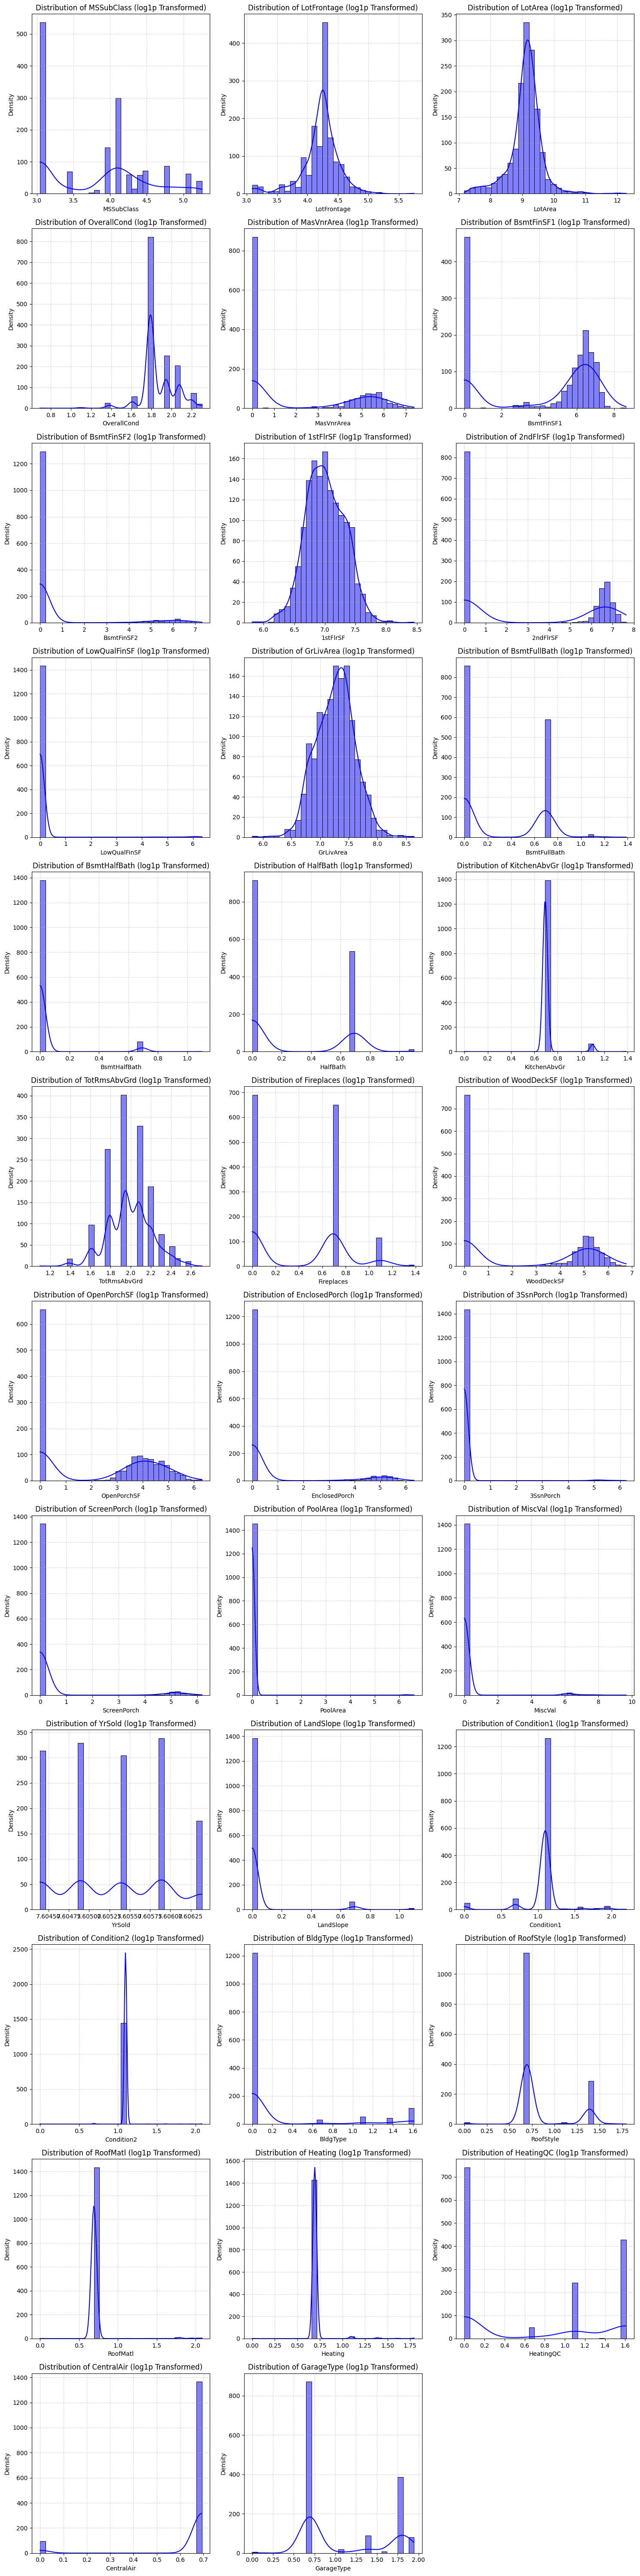

In [29]:
import math

# Determine grid dimensions
num_cols_to_plot = len(train_better_columns)

num_rows = math.ceil(num_cols_to_plot / 3) 

# Create the figure and subplots
plt.figure(figsize=(15, 5 * num_rows)) # Adjust total figure size dynamically

for i, col in enumerate(train_better_columns, 1): # Start enumeration from 1 for subplot indexing

    train_encoded[col] = np.log1p(train_encoded[col])
    test_encoded[col] = np.log1p(test_encoded[col])

    # Create subplot
    plt.subplot(num_rows, 3, i) # (rows, columns, current_plot_index)

    # Plot the distribution
    sns.histplot(train_encoded[col], kde=True, bins=30, color='blue')

    # Set titles and labels for the current subplot
    plt.title(f'Distribution of {col} (log1p Transformed)', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Density', fontsize=10) # Changed from 'Frequency' to 'Density' as kde=True implies density
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

## Feature Scaling

In [30]:
from sklearn.preprocessing import StandardScaler

scaler =  StandardScaler()
scaler.fit(num_train_df.drop("SalePrice", axis=1))
num_train_scaled = scaler.transform(num_train_df.drop("SalePrice", axis=1))
num_test_scaled = scaler.transform(num_test_df)

In [31]:
num_train_transformed = pd.DataFrame(
    num_train_scaled,
    columns=num_train_df.drop(columns=['SalePrice']).columns,
    index=num_train_df.index
)
num_test_transformed = pd.DataFrame(num_test_scaled, columns=num_test_df.columns, index=num_test_df.index)

train_transformed = pd.concat([num_train_transformed, cat_train_encoded, num_train_df["SalePrice"]], axis=1)
test_transformed = pd.concat([num_test_transformed, cat_test_encoded], axis=1)

train_transformed.shape, test_transformed.shape

((1460, 75), (1459, 74))

## Understanding correlation between features

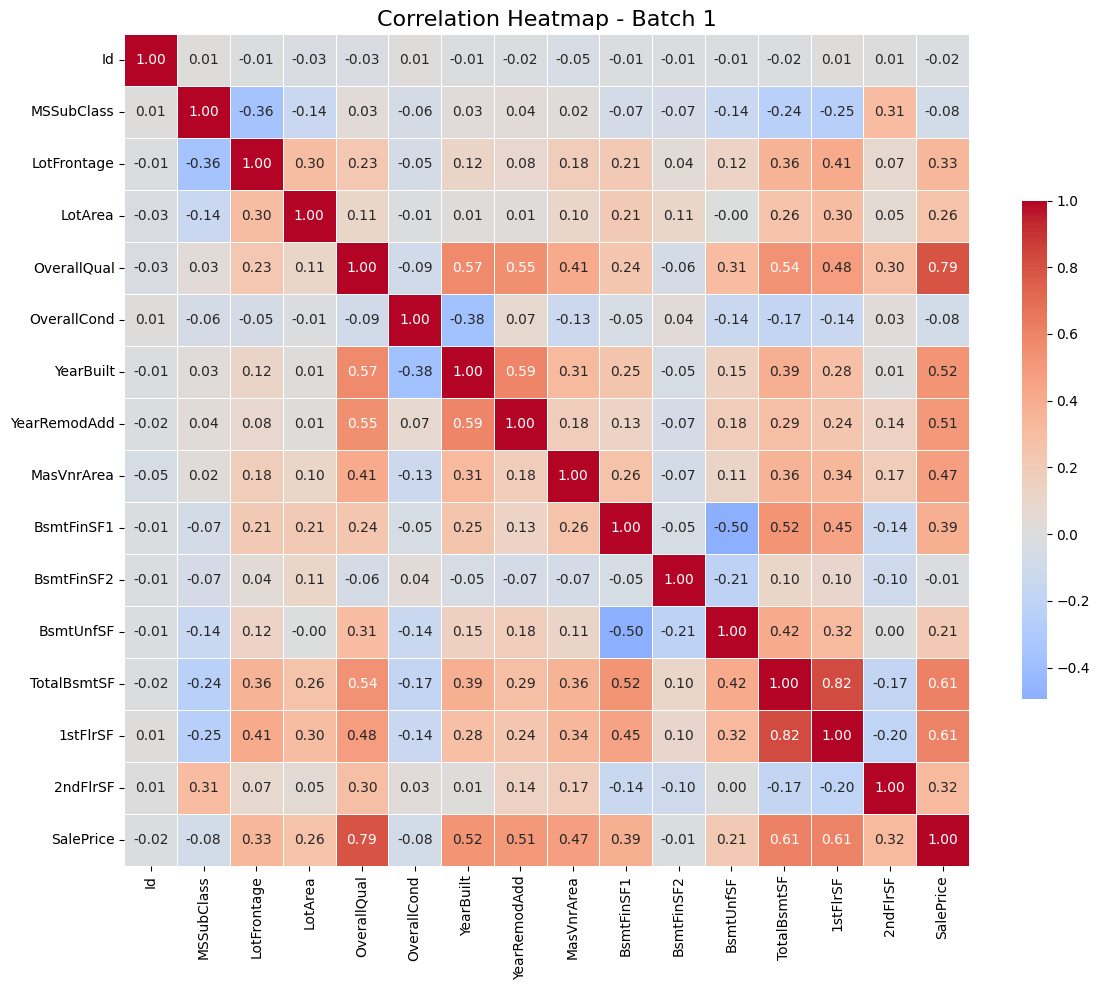

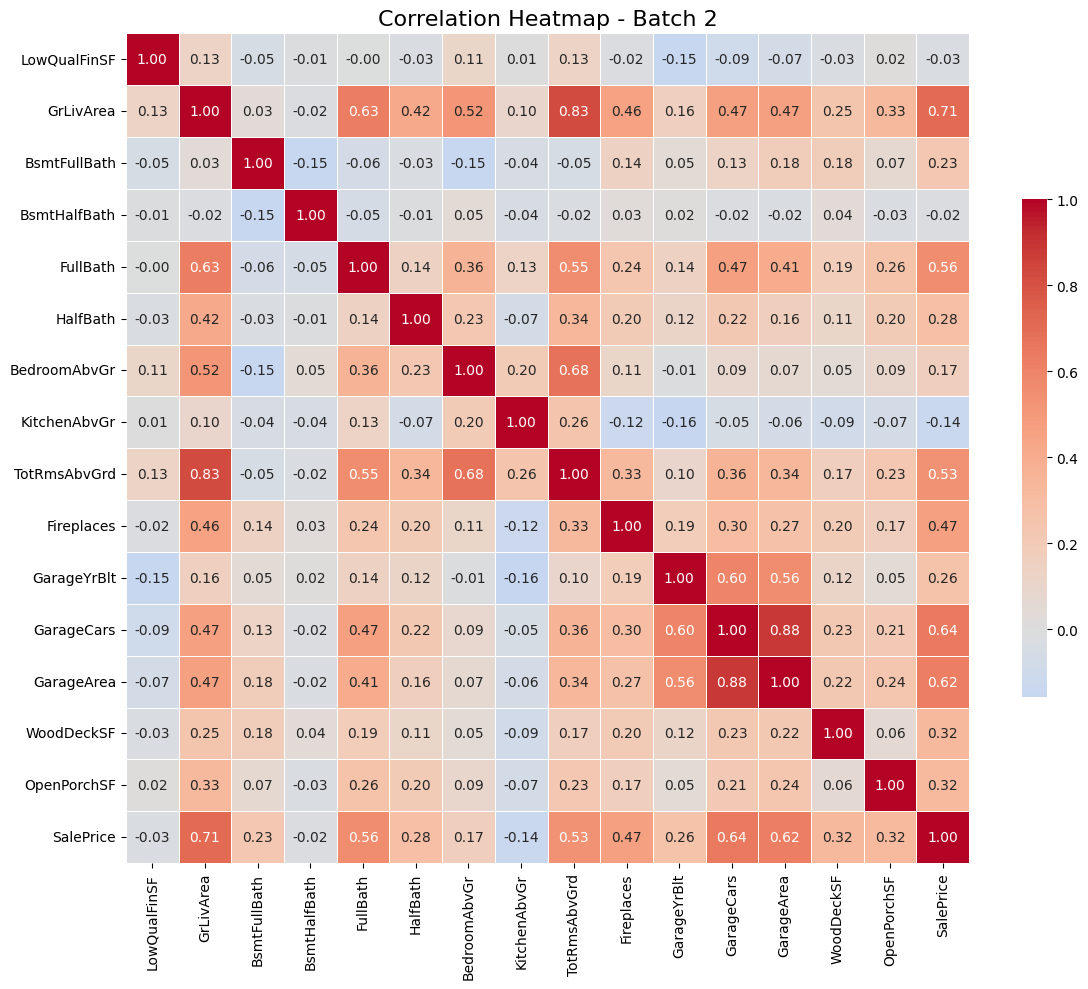

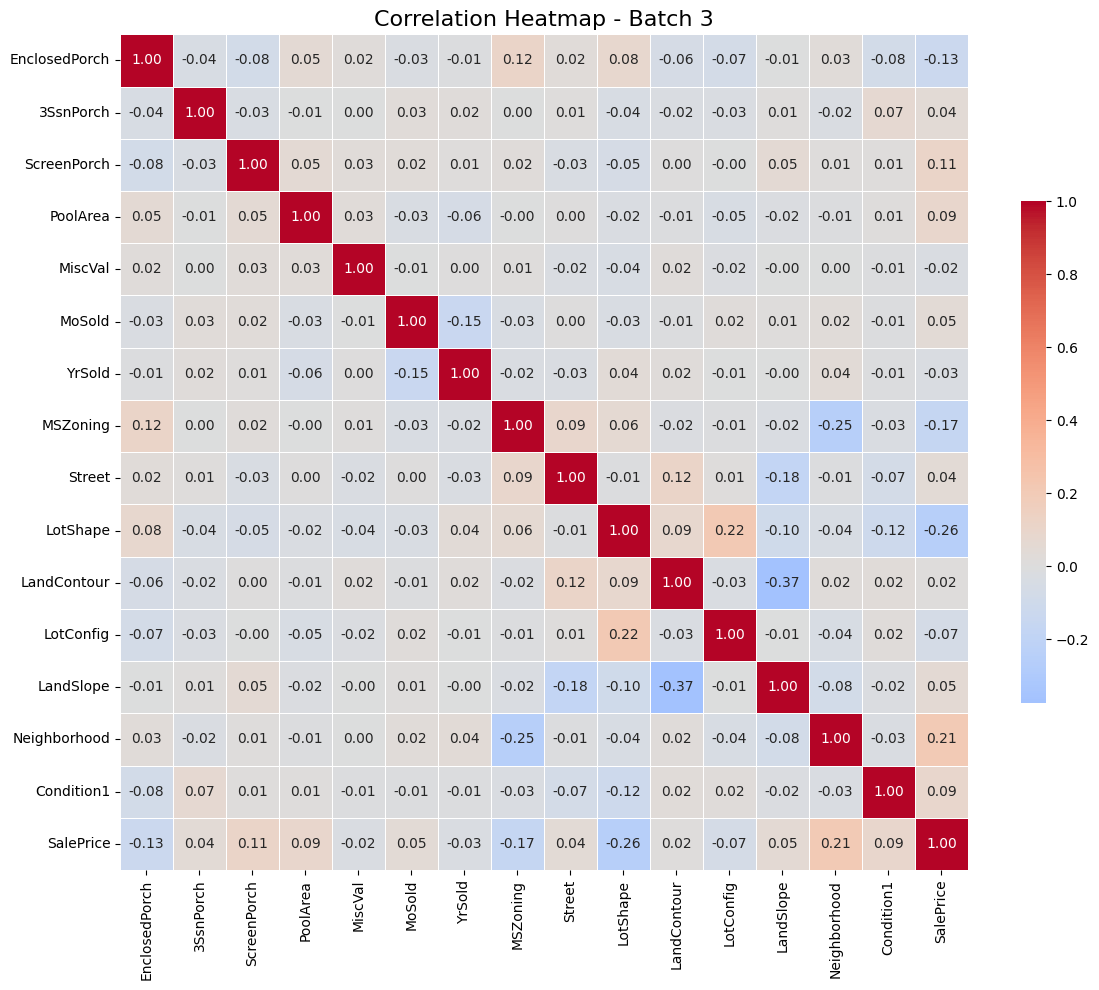

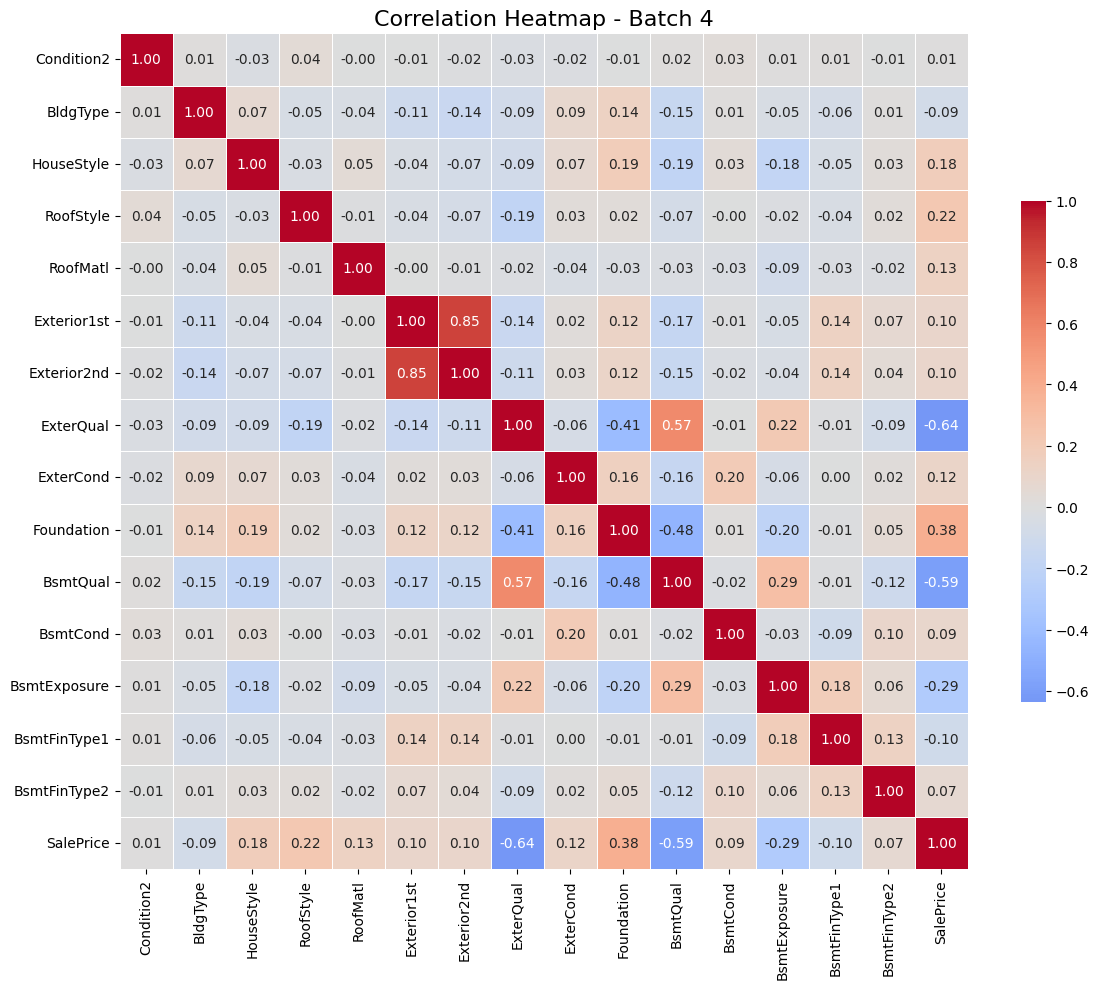

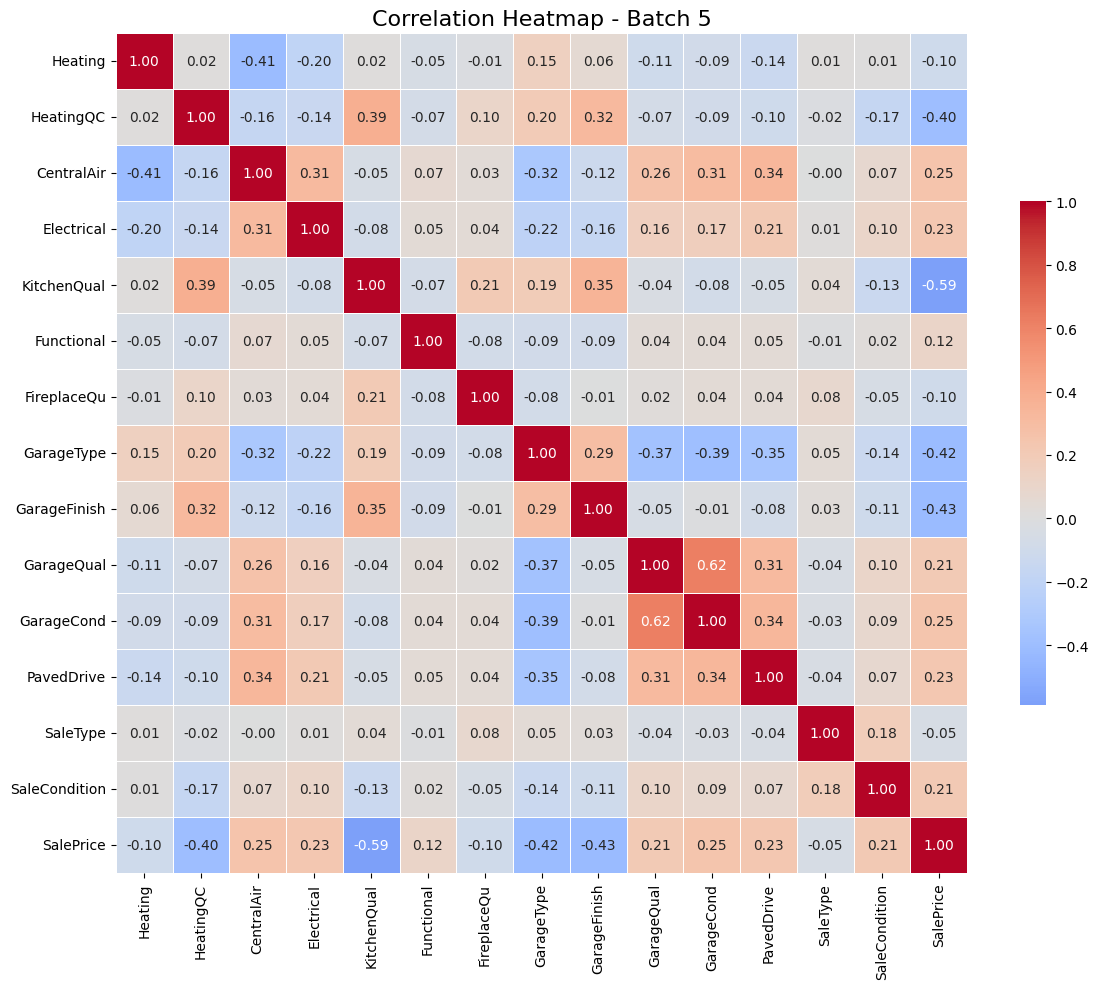

In [32]:
corr_matrix = train_transformed.corr(numeric_only=True)

features = [col for col in corr_matrix.columns if col != "SalePrice"]

batch_size = 15
feature_batches = [features[i:i + batch_size] for i in range(0, len(features), batch_size)]

for i, batch in enumerate(feature_batches, 1):
    cols_to_plot = batch + ['SalePrice']
    corr_subset = corr_matrix.loc[cols_to_plot, cols_to_plot]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_subset,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        center=0,
        linewidths=0.5,
        cbar_kws={'shrink': 0.6}
    )
    plt.title(f'Correlation Heatmap - Batch {i}', fontsize=16)
    plt.tight_layout()
    plt.show()

### Model Initialization, Hyperparameter tuning and training

In [33]:
X = train_transformed.drop(["SalePrice"], axis=1)
y = train_transformed["SalePrice"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1168, 74), (292, 74), (1168,), (292,))

In [34]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    # Set reasonable defaults for parameters we are NOT tuning in this quick search
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.005, # A small L1 regularization can often help
    reg_lambda=1    # Default L2 regularization
)

In [35]:
param_distributions = {
    'n_estimators': np.arange(100, 801, 100),  # A reasonable range for n_estimators
    # THIS IS THE MOST IMPORTANT CHANGE:
    'learning_rate': np.logspace(-3, -1, 20),  # Common range: 0.001 to 0.1, with 20 values
                                              # (This is np.arange(0.001, 0.1, 0.005) on a log scale)
    'max_depth': np.arange(3, 8, 1),           # Keep this range or slightly expand if needed
}

In [36]:
# Print a summary of the streamlined search space
print("\n--- Streamlined Hyperparameter Search Space ---")
for param, dist in param_distributions.items():
    if isinstance(dist, np.ndarray):
        print(f"{param}: min={dist.min():.4f}, max={dist.max():.4f}, num_values={len(dist)}")
    else:
        print(f"{param}: {dist}")


--- Streamlined Hyperparameter Search Space ---
n_estimators: min=100.0000, max=800.0000, num_values=8
learning_rate: min=0.0010, max=0.1000, num_values=20
max_depth: min=3.0000, max=7.0000, num_values=5


In [37]:
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

#### Hyperparameter Tuning Using RandomizedsearchCV

In [38]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=15,                  # Significantly reduced iterations
    scoring='neg_mean_squared_error',
    cv=cv_strategy,
    verbose=2,                  # Still show progress
    random_state=42,
    n_jobs=-1,                  # Use all cores where possible
    return_train_score=False,   # No need for train scores for quick search
    refit=True
)

In [39]:
# --- 6. Perform the Search ---
print("\n--- Starting Streamlined Randomized Search CV ---")
random_search.fit(X_train, y_train)
print("\n--- Streamlined Randomized Search CV Complete ---")

# --- 7. Analyze Results ---

# Best parameters found
print("\nBest hyperparameters found:", random_search.best_params_)

# Best score (negative MSE, convert to positive MSE)
best_mse = -random_search.best_score_
print(f"Best cross-validation MSE: {best_mse:.4f}")


--- Starting Streamlined Randomized Search CV ---
Fitting 5 folds for each of 15 candidates, totalling 75 fits

--- Streamlined Randomized Search CV Complete ---

Best hyperparameters found: {'n_estimators': np.int64(600), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.0379269019073225)}
Best cross-validation MSE: 740097708.8000


## Model Prediction and Evaluation

In [40]:
best_xgb_model = random_search.best_estimator_

# Evaluate on the test set
y_pred = best_xgb_model.predict(X_valid)
test_mse = mean_squared_error(y_valid, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_valid, y_pred)

In [41]:
print(f"\nTest Set Metrics (Best Model from Quick Search):")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"R-squared (R2): {test_r2:.4f}")


Test Set Metrics (Best Model from Quick Search):
Mean Squared Error (MSE): 610861376.0000
Root Mean Squared Error (RMSE): 24715.6100
R-squared (R2): 0.9204


## Predictions for kaggle Competition

In [42]:
X_test = test_transformed

In [43]:
pred_xgb = best_xgb_model.predict(X_test)

In [46]:
sub = pd.DataFrame()
test_ID = test['Id']
sub['Id'] = test_ID
sub['SalePrice'] = pred_xgb
sub.to_csv('submission.csv', index=False)

## Conclusion

This project successfully developed a robust predictive model utilizing the powerful XGBoost algorithm. Through a meticulous hyperparameter tuning process, a highly optimized XGBoost model was identified, demonstrating its capacity for effective learning from the data.

The model's performance was rigorously evaluated on a dedicated test set, yielding impressive results:

1] Mean Squared Error (MSE): 610,861,376.00

2] Root Mean Squared Error (RMSE): 24,715.61

3] R-squared (R2): 0.9204

The outstanding R-squared value of 0.9204 signifies that the model accounts for over 92% of the variance in the target variable, reflecting its strong predictive power and excellent fit to the underlying patterns in the data. The achieved RMSE indicates a consistent level of predictive accuracy.

Further validating its generalization capabilities, the model's predictions were submitted to a Kaggle competition, where it achieved a commendable score of 0.13469. This external validation underscores the model's ability to perform effectively on unseen, real-world data, demonstrating its practical applicability and solid performance in a competitive environment.